In [1]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForMaskedLM, AutoTokenizer
import random
import csv
import re
from collections import defaultdict
from tqdm import tqdm


CSV_PATH = "esm35M_500k_neuron_explanations.csv"  
MATCH_STRING = "zinc finger"           
MODEL_NAME = "facebook/esm2_t12_35M_UR50D"
SEQ_LEN = 800
NUM_STEPS = 100
A = 8
B = 3.5


def find_matching_neurons(csv_path, keyword):
    matches = []
    with open(csv_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) < 2:
                continue
            neuron_id = row[0]
            if any(keyword in desc.lower() for desc in row[1:]):
                m = re.match(r"layer_(\d+)_neuron_(\d+)", neuron_id)
                if m:
                    matches.append((int(m.group(1)), int(m.group(2))))

    print(matches)
    return matches

# ----------------------------
# HOOK + SAMPLING UTILS
# ----------------------------
def make_multi_neuron_hook(neurons, a=10.0, b=3.0):
    def hook_fn(module, input, output):
        for neuron in neurons:
            output[:, :, neuron] = a * output[:, :, neuron] + b
        return output
    return hook_fn

def random_protein_sequence(length):
    return ''.join(random.choices("ACDEFGHIKLMNPQRSTVWY", k=length))

def sample_from_logits(logits):
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, num_samples=1).squeeze(-1)

def decode_tokens(tokenizer, token_ids):
    return tokenizer.decode(token_ids, skip_special_tokens=True).replace(" ", "")

# ----------------------------
# MAIN STEERING LOOP
# ----------------------------
def steer_sequences():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
    model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(device)
    model.eval()

    # Load neurons to steer
    matched_neurons = find_matching_neurons(CSV_PATH, MATCH_STRING)
    if not matched_neurons:
        print("No matching neurons found.")
        return

    # Organize by layer
    layer_to_neurons = defaultdict(list)
    for layer, neuron in matched_neurons:
        layer_to_neurons[layer].append(neuron)

    best_sequence = None
    best_score = -float('inf')
    history = []  # Store (sequence, activation) pairs

    for step in tqdm(range(NUM_STEPS)):
        seq = random_protein_sequence(SEQ_LEN)
        inputs = tokenizer(seq, return_tensors="pt").to(device)

        # Register hooks
        handles = []
        for layer, neurons in layer_to_neurons.items():
            hook = model.base_model.encoder.layer[layer].intermediate.register_forward_hook(
                make_multi_neuron_hook(neurons, A, B)
            )
            handles.append(hook)

        # Forward pass
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits[0]
            hidden_states = outputs.hidden_states

        # Remove hooks
        for h in handles:
            h.remove()

        # Score: average activation across all target neurons
        total = 0
        count = 0
        for layer, neurons in layer_to_neurons.items():
            h = hidden_states[layer][0]
            for n in neurons:
                total += h[:, n].mean().item()
                count += 1
        avg_act = total / count if count > 0 else 0

        # Sample sequence
        sampled_ids = sample_from_logits(logits)
        new_seq = decode_tokens(tokenizer, sampled_ids)

        # Save to history
        history.append((new_seq, avg_act))

        if avg_act > best_score:
            best_score = avg_act
            best_sequence = new_seq

        print(f"[{step+1:03}] avg_activation={avg_act:.4f} | {new_seq}")

    print("\n=== Best Sequence ===")
    print(best_sequence)
    print(f"Max avg activation: {best_score:.4f}")

    # Optional: save to CSV
    with open("steered_sequences.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["sequence", "avg_activation"])
        for seq, act in history:
            writer.writerow([seq, act])

# Run
steer_sequences()


Some weights of the model checkpoint at facebook/esm2_t12_35M_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[(0, 50), (0, 104), (2, 451), (3, 67), (3, 200), (3, 196), (3, 266), (3, 316), (3, 342), (3, 352), (3, 457), (8, 411), (11, 392)]


  5%|▌         | 5/100 [00:00<00:09,  9.96it/s]

[001] avg_activation=0.1583 | MKLACMDGAMIFIIGRGSIVWQMLVQLTDILYRMMMESXMYAMCVFQPCRNMKSNLVNVEAAAESGGLNLITSSPTEEVIKIMVLLGEMMRVEKKLYFNMRMEMGNMXASDKLPMEVLYRFLRGEAFKGKLGRSKEICPLSVRDNLMTLMMMMHTIVSHIFNNRNVMKESEKHIEEELPTYCSVTMQDSGLQGAGLLTFPLFQANVSWRLLKAVQYSPLASLDVDLMMMMGLQIMTNTVGEIQEMSVFLTGTEDAVLMIMAVMKFTRLSDVFVKLDDVEEVEQLEERHMAPLVKSGDLWCSWRRKNFTRNVVDPCIMQVAIEEQAMDFMDMMMQMTMTMVCAWKVGVVKTVGLETGAWKXMMQVFYMIQGLEDKITVWRGRSMMQKFGKATKVKMPVMLMWRMVVQMFDFVDTLWCHVQRTTRELQPSEGRGCDKGADAGKREVWGWENAFRLRSFPEKCEWMHPEPDCISGCGLTICNNIGLCVDKEFVATVHVKNMNGMLEAGMMAVSGPDMRIVCGKSLVRGQKEGQDPMCFGRAGEGPQPVTAWVGVGRSNNPTLIPIGIVYPTRMMIERMAKEHTDGVSAPMVPNLRMYRTEFSVDQCVKYLYLRCGKIECLNEPGEPKDKSDFHIARVKADIIESCYPSEKIQKVQTLGGKIKSDVVFCTARDNRWGIAGEIPLENNNTPYLPAETYIFESGNLCGLGVWKEWERRLDSINPSNIY
[002] avg_activation=0.1515 | MRMGEFYQAGNVPKILKLVKIRGKFYIRIMRRALYQGDDMEETMGLFPEMSAMMVTVQTQFWKRTAIVEIIMDMFQTQGAGMINITDTAIVFIVRRSKQISGMDMMGTIGHPYWGFYIAYKLRWRHIVRLNNKLAQKPFRDFECGSSMAVNPMLGEYQMMMTYHVQLSKPNCENSLLCHGATRSMGEGINRAGEFDRKCKTSAEFKEGWVCWILAIT

 13%|█▎        | 13/100 [00:00<00:03, 21.82it/s]

[009] avg_activation=0.1614 | MLQRRMCVIRNMSNRVDAVMTMMRKRGAMLVDYFMSMERWYPELIGRSWSKAMMMGHRMFDXYDGQVSRKVLYCVICYQLTSKRMYRFGQMVLITFWMRIMMTQSFRQAFELLIMDTMLIIPRWIVAEIVPMGAMTYMMMLAMRMIHFNGSLQMCFPLSLPPLGASAGVRKKVLFSGIFLKYFNTGVIGLGWLDMVMKEFAAMMYFIDQLTFHNLHGIVDDSLHQPEDCFAWMDMREIASRILAEIEYFWGVPEPDLVAQQAEWWLLTVRQYAQQDALMEQMFQLQVKMINDLHVVASYERMLVFTRWRQLEDLVVCPLCSQSTKVLRIMPVAIERGLHGEDKSLALDYALWGRSVCECSILTVMMMVAVMMRTDAIRGTRQTLLNRLSAIHKWTRVQSGLNAAMQGLALVCVDYRAARFKGVDLFINWSMNMAHCVADRLENGWTRLVQCGCVYSRRKGMEWIDSDVAVPYMNLEQKENQRAITVSSKTHEQWYGDLLKYTECETTVTMKEVDAKYALRNDVYLEAMMMDKLERAMGIVVLQAQMMSGFERFSMYACILGNAQREILLQIVMAQWIGELQQETYFNSPKGEMEQRNQIIGMQTAEKREVHCLRNNATPYDNDSCCQKLFRPYPGRMPGLCLRMTSSLQTDASVDQIRTEILGGSSMHIRGRVYCIADFGNEIRCQPMSLISVWQLLQEKLDLEIVSTREVGKRPEPIWEVPVNLRV
[010] avg_activation=0.1514 | MANMCFGAMMAFVLSPDRSWQFCGIGHFPMSMLQRFSDEATGYLGNMWVQELLLWAYIPTGAGKELAWCLYLLLFFTPLCWVNLKVLKMLAMMVLVAWRMMEVAIRLIYMILKIMMIMIHLMNAEVFIIWGYLFLFRINRTGKPARMPKSLLIYLIIENENDVPQEDMNWVFDGFGLYSARRLWTRVERIRSQAIAGMKAGVIDLMPLHWLL

 21%|██        | 21/100 [00:01<00:02, 28.86it/s]

[017] avg_activation=0.1673 | MDMLDMKRVGGAAMTIKQVQMAGKDMSKVGILLNGGMQVVMQLPLYPAGYPAFTLACLATKMIPFAMVDPMRAPVQMKEGWTGIVMEXCNFLCLGSFKSICLISTFALHKIQNMEGGFDMVYLIVLMGYSKIIHKEVNNFKLAGFEIGHDVVTFKKYGNNAGDMTPFRETVQRLLGANVYNVGISDPWGNYAAYSMVIEDTGAGHGLVQCVMTIHWKDRMYMMPWRTMMHKXMVTADKASSGQELDVFNMEVFLKACSKKRCLCIPGVVTQIDILDQAGVCILGTIRKFQISASNKTIWPLQFFYIEIPVLANDDNMVRRPMEYTEHYQHGGSIYDDSVMKPMALTLQRKLMIGNDKDIYSVMQELLVIIYTTFGVMRRPFALGDQQHLKAMMMILEIDYVLLMLMMYKEPIRYKVGMMNNLILGKAIATERFGQAVVWAMEVQLQFMGQCLMMNMAMMMLYLQMSMLVGERFATSMRFQECDQLAMKALPLGIKRSFYLPVNWYISAQKYPTKHRRQILKLQRGCPKVMLHNILRLYGRFVHLVTLDLVLMFCVMXMLVSFSCKMTMTDMTVMLRMVQWLDQDAIHVKARELFPIDFAATHGVRILHCPVRWRGTEVLHWPMKNYGYCTTVNFGFSRCHLLPESKVIAGVASTRPGVSQEQSNCRFGGECWPLQKAYIAITNPTVACKRRNGDKITAHFKIINHYYKSKFCLGLKLAFMACADKTTNYL
[018] avg_activation=0.1389 | MMMMVMSTHIVIMMPFPEMMRNVLXCDVWRLVLCCIMYYLGERGTMQSQFQVSYERWHRVSEAAKDRLRRPLPIDMIFEQWNLGGQAALRVTSRFVTLKIVFNQALFWPLAEVFNMAMMMMMMFRLKLMMLXLQYRYMTMIIFQDVASYKLIRRGVAWVLGMGANVLIIQYSRALEKNFDIAMEQRSKQMSRHHTGMEMRAEVGNRVFI

 25%|██▌       | 25/100 [00:01<00:03, 21.10it/s]


[025] avg_activation=0.1565 | MLDEVNFIHIFVDPVDPINRLPNFPLFRRIPIPNXMMMLHRGITFRLVEXMEGLGVVQLWMVDTCPALFKLDKIVYNQTMMMRMFAKMRMMLVWMDMCMMGMMANVLSMERPDVDSIFIFCMNLCFTYIVQETNCEIRKEGFRSVECCQLCGQVGKMQHVMMIIVLWGMYAFEFPHAKCMFRVRWKIEPVITPHTHIVVANNVLVVGDERNEKRMMGSLRPKYMLITFACLLFGMARENIAEVQVSPGLGMAYFEAMELFQTAVERICAEEDFKRRDDYMEKKCDNFNVINAIDFAEDIVQDGRCFVLRDQYVIVIYLKHAQLNFGEFRSILFRLFCGYDDLTAMMANSWREREQLWEIAVQQKKAVTLISNAYRAYLCKINPMTPKLVASRELMEKETDDDKMMHIKPYYYLLRFDCKYTCNGSFEHMMDSYLDNDLTVHRSSIITEDMFICKIIKILMPEQLGFYLHLYRVLMCEIGFSKIIQGXYSTMITAIVNMCKVMMLPIFWLSVLCGPFVYDXVAGQNDQIRYFTMISIYPFQWVHINNHEIERKFALATEILRRWKRIMIFRALLQTDWVCSVIRGVNLIATPDDMDIHSCRQRETVTIGRKKNFIDDVGWCFQSEQTDQPRIGVTKRITEGLQADGTSPTVFDVELWLTIEFGWVHVGVQDNGVVIDEKTRSSQQHNYTNMAGFHREGVDFYVSMLKPCYGEASVQTSFAKGHGDNLFQKPTVQSDAFARMLLQAKWPQRLDKVEKR


KeyboardInterrupt: 

In [ ]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

def compute_gravy_ignore_x(seq):
    cleaned = seq.replace("X", "")  # Remove unknowns
    if not cleaned:
        return None  # No valid amino acids
    return ProteinAnalysis(cleaned).gravy()
# Example
protein_seq = "QQDAQKAQQQDQQQNRNTNQQAQTQQNQQNNQNGNTTRQQQQEANGQNQEQQ"  # replace with your sequence
gravy_score = compute_gravy_ignore_x(protein_seq)



In [ ]:
print(gravy_score)

In [4]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForMaskedLM, AutoTokenizer
import random
import csv
import re
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Configuration
CSV_PATH = "esm35M_500k_neuron_explanations.csv"
MATCH_STRING = "negative gravy"
MODEL_NAME = "facebook/esm2_t12_35M_UR50D"
SEQ_LEN = 50
NUM_STEPS = 100
A = 5
B = 3

# Utility: Find neurons matching a keyword in the explanation CSV
def find_matching_neurons(csv_path, keyword):
    matches = []
    with open(csv_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) < 2:
                continue
            neuron_id = row[0]
            if any(keyword in desc.lower() for desc in row[1:]):
                m = re.match(r"layer_(\d+)_neuron_(\d+)", neuron_id)
                if m:
                    matches.append((int(m.group(1)), int(m.group(2))))
    return matches

# Utility: Make steering hook for multiple neurons
def make_multi_neuron_hook(neurons, a=10.0, b=3.0):
    def hook_fn(module, input, output):
        for neuron in neurons:
            output[:, :, neuron] = a * output[:, :, neuron] + b
        return output
    return hook_fn

# Utility: Random valid protein sequence
def random_protein_sequence(length):
    return ''.join(random.choices("ACDEFGHIKLMNPQRSTVWY", k=length))

# Utility: Sample from logits
def sample_from_logits(logits):
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, num_samples=1).squeeze(-1)

# Utility: Decode token IDs into a protein sequence string
def decode_tokens(tokenizer, token_ids):
    return tokenizer.decode(token_ids, skip_special_tokens=True).replace(" ", "")

# Utility: Compute GRAVY score ignoring unknown residues
def compute_gravy_ignore_x(seq):
    cleaned = seq.replace("X", "")
    if not cleaned:
        return None
    return ProteinAnalysis(cleaned).instability_index()

# Main steering function
def steer_sequences():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
    model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(device)
    model.eval()

    matched_neurons = find_matching_neurons(CSV_PATH, MATCH_STRING)
    if not matched_neurons:
        print("No matching neurons found.")
        return

    layer_to_neurons = defaultdict(list)
    for layer, neuron in matched_neurons:
        layer_to_neurons[layer].append(neuron)

    best_sequence = None
    best_score = -float('inf')
    history = []  # Each item: (sequence, activation, gravy)

    for step in tqdm(range(NUM_STEPS)):
        seq = random_protein_sequence(SEQ_LEN)
        inputs = tokenizer(seq, return_tensors="pt").to(device)

        # Register steering hooks
        handles = []
        for layer, neurons in layer_to_neurons.items():
            hook = model.base_model.encoder.layer[layer].intermediate.register_forward_hook(
                make_multi_neuron_hook(neurons, A, B)
            )
            handles.append(hook)

        # Forward pass with hooks
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits[0]
            hidden_states = outputs.hidden_states

        # Remove hooks
        for h in handles:
            h.remove()

        # Score: average activation across target neurons
        total, count = 0, 0
        for layer, neurons in layer_to_neurons.items():
            h = hidden_states[layer][0]
            for n in neurons:
                total += abs(h[:, n].mean().item())
                count += 1
        avg_act = total / count if count > 0 else 0

        # Sample sequence and compute GRAVY
        sampled_ids = sample_from_logits(logits)
        new_seq = decode_tokens(tokenizer, sampled_ids)
        gravy = compute_gravy_ignore_x(new_seq)

        # Save results
        history.append((new_seq, avg_act, gravy))
        if avg_act > best_score:
            best_score = avg_act
            best_sequence = new_seq

        gravy_str = f"{gravy:.4f}" if gravy is not None else "N/A"
        print(f"[{step+1:03}] avg_activation={avg_act:.4f} | gravy={gravy_str} | {new_seq}")

    # Print best result
    print("\n=== Best Sequence ===")
    print(best_sequence)
    print(f"Max avg activation: {best_score:.4f}")

    # Save history to CSV
    with open("steered_sequences.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["sequence", "avg_activation", "gravy"])
        for seq, act, gravy in history:
            writer.writerow([seq, act, gravy])

    # Plot GRAVY score over steps using seaborn
    df = pd.DataFrame(history, columns=["sequence", "activation", "instability index"])
    df["step"] = df.index + 1

    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df, x="step", y="instability index", marker="o", label="instability index")
    plt.xlabel("Step")
    plt.ylabel("instability index")
    plt.title("instability index Trajectory During Steering")
    plt.tight_layout()
    plt.savefig("instability_index_seaborn.png")
    plt.show()

# Run
if __name__ == "__main__":
    steer_sequences()


Some weights of the model checkpoint at facebook/esm2_t12_35M_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  1%|          | 1/100 [00:00<00:21,  4.69it/s]

[001] avg_activation=7.5705 | gravy=53.0804 | GGGQQGQDGNGNDNAQNDDQNGNQNQQKQQNANTQQDQQQXSDGNQEQQNEQ


  2%|▏         | 2/100 [00:00<00:21,  4.65it/s]

[002] avg_activation=7.5724 | gravy=80.7580 | QQQQQTQQGQNQDLQRXNQQGQRQQQRTNNQQNQQQNQNRQQQNQNQQQQQ


  3%|▎         | 3/100 [00:00<00:20,  4.66it/s]

[003] avg_activation=7.5771 | gravy=55.0902 | TDNQXGQQQQQVNNNAQQDAQQTQQTDNSYGDTADNGQNNQQDQQQQTSQQQ


  4%|▍         | 4/100 [00:00<00:20,  4.67it/s]

[004] avg_activation=7.5840 | gravy=23.6588 | QNQQNDQQQNTNNXDDGDTQNGNQQNNQQHGQNQNGQQDGNQERQDQNEQLD


  5%|▌         | 5/100 [00:01<00:20,  4.69it/s]

[005] avg_activation=7.5691 | gravy=66.4451 | QDQPQTGGGQQNNKGQSQNQCQNQNQTQNQQTQQQQLEVQTEDQXNGQQQQQ


  6%|▌         | 6/100 [00:01<00:20,  4.66it/s]

[006] avg_activation=7.5445 | gravy=55.3615 | NQVKQDQQNNASGNNNEDNQGSGNDQTDQPQDDTGQNQSSQDGEQQNNHQQD


  7%|▋         | 7/100 [00:01<00:20,  4.65it/s]

[007] avg_activation=7.6017 | gravy=49.3750 | ENQQARNANNDQQQQGNANQADTQQLNQQNQTQQKQNQNNQDQGERQQQQQD


  8%|▊         | 8/100 [00:01<00:19,  4.64it/s]

[008] avg_activation=7.5676 | gravy=52.4750 | QSDQDGQTQGQQNQGGNQQQQQNGQQEQNQGDQQNQADSQGDDDQNENQNQQ


  9%|▉         | 9/100 [00:01<00:19,  4.63it/s]

[009] avg_activation=7.5471 | gravy=70.3882 | QQQQNEDDQNDQNDQQGQQNQTQNQDQQQQTQQNSSDXQQNDDQQQQQTQQN


 10%|█         | 10/100 [00:02<00:19,  4.63it/s]

[010] avg_activation=7.5736 | gravy=40.8481 | QDQQNGDNNQPQTSLGQDQQQAQQDQDNTQENQQGQTADQNNEGQNQNQGDQ


 11%|█         | 11/100 [00:02<00:19,  4.63it/s]

[011] avg_activation=7.5551 | gravy=68.0451 | RQTQDNQGQQQGQNQQGNPQQQDQNQNLQQQGNQXQQSDEQGQQNQNGQQNQ


 12%|█▏        | 12/100 [00:02<00:19,  4.62it/s]

[012] avg_activation=7.5620 | gravy=93.7038 | EQDQNNQQNQQQDNQLNQQQDNQQDQNNEQQPQGQQPQDQNDQDQQQGEQDS


 13%|█▎        | 13/100 [00:02<00:18,  4.61it/s]

[013] avg_activation=7.5911 | gravy=41.4608 | GQNQQNGNQGGLEADAEDQTQAESXNNQQQSQNDENRNNGQGMQQQQQNGDN


 14%|█▍        | 14/100 [00:03<00:18,  4.61it/s]

[014] avg_activation=7.6103 | gravy=70.1577 | QQNQAATQNQQQQQQQQQQSNNNNNNAQNGEQQGQNGGGGEQDNQPGDDQDE


 15%|█▌        | 15/100 [00:03<00:18,  4.61it/s]

[015] avg_activation=7.5562 | gravy=86.6880 | QQQEGTSSQQTGQADQQQQGNQQQGQQGQQTQQQQXSNQGNQSDKNXQQQQQ


 16%|█▌        | 16/100 [00:03<00:18,  4.61it/s]

[016] avg_activation=7.5813 | gravy=74.7135 | QQQGQQDDQNQQQGGNQAQLSTAQDNHQEPNEAQCQPQDQTQQQSQQQLSAQ


 17%|█▋        | 17/100 [00:03<00:17,  4.63it/s]

[017] avg_activation=7.5586 | gravy=63.4865 | QGQDQNQQQDKNQQQRAEQGQQKNQQQLGSQTDTSQRADTNNQDQQSGQQQQ


 18%|█▊        | 18/100 [00:03<00:17,  4.66it/s]

[018] avg_activation=7.5680 | gravy=46.0635 | QADGQHQQNQQQQTQQQNGQQQQNQNQGQQQGCQGQNQNQNQQAQQNGGGGL


 19%|█▉        | 19/100 [00:04<00:17,  4.68it/s]

[019] avg_activation=7.5886 | gravy=38.3635 | QNDDNQTSNGGEQNNQQQTNQQEDEQNNNQTSDQQQQATEENNQMGQGTGNQ


 20%|██        | 20/100 [00:04<00:17,  4.70it/s]

[020] avg_activation=7.5641 | gravy=56.0373 | NQQQNNNQGLAQNGNQDNNGDQGXEGQKQNRDQHSQSQLQQQQQQDQNDQNQ


 21%|██        | 21/100 [00:04<00:16,  4.72it/s]

[021] avg_activation=7.6648 | gravy=106.5769 | QQDQAQQQQLQQGDQNQQQTQNQQQEQQQQQQPQGQQGQQGQQDNDQQNQQP


 22%|██▏       | 22/100 [00:04<00:16,  4.73it/s]

[022] avg_activation=7.5670 | gravy=70.0288 | NNQGQTQTNQQQQTQQQQNNQSGQSEQQQQNQQNQDNSNQQQNAQNNVNSQC


 23%|██▎       | 23/100 [00:04<00:16,  4.75it/s]

[023] avg_activation=7.5600 | gravy=33.6077 | QQDDNSQQNDDQNQQQAQNQNTQQNQNNNTNQQANNFQNQQQQGQNQQNANQ


 24%|██▍       | 24/100 [00:05<00:15,  4.76it/s]

[024] avg_activation=7.5768 | gravy=38.3510 | QAQNQNGQNQQNQXNDNNQDTGDQQNQQNNQQQNNATQQENNQAEDQQLQQT


 25%|██▌       | 25/100 [00:05<00:15,  4.78it/s]

[025] avg_activation=7.5750 | gravy=71.5900 | IDSNQQQQTQQQGQQNGQQDGDAGQNXTQQNQQQAQQQQDQXTNQQQIQDQQ


 26%|██▌       | 26/100 [00:05<00:15,  4.65it/s]

[026] avg_activation=7.5685 | gravy=59.9300 | DXQQDQQGNPQQNYQQQQDNNRQGQQGEQDDQQQNGQGDNNNQXGAQDNQNS


KeyboardInterrupt: 

In [5]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForMaskedLM, AutoTokenizer
import random
import csv
import re
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Configuration
CSV_PATH = "esm35M_500k_neuron_explanations.csv"
MATCH_STRING = "positive gravy"
MODEL_NAME = "facebook/esm2_t12_35M_UR50D"
SEQ_LEN = 50
NUM_STEPS = 100
A = 5
B = 3

# Utility: Find neurons matching a keyword in the explanation CSV
def find_matching_neurons(csv_path, keyword):
    matches = []
    with open(csv_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) < 2:
                continue
            neuron_id = row[0]
            if any(keyword in desc.lower() for desc in row[1:]):
                m = re.match(r"layer_(\d+)_neuron_(\d+)", neuron_id)
                if m:
                    matches.append((int(m.group(1)), int(m.group(2))))
    return matches

# Utility: Make steering hook for multiple neurons
def make_multi_neuron_hook(neurons, a=10.0, b=3.0):
    def hook_fn(module, input, output):
        for neuron in neurons:
            output[:, :, neuron] = a * output[:, :, neuron] + b
        return output
    return hook_fn

# Utility: Random valid protein sequence
def random_protein_sequence(length):
    return ''.join(random.choices("ACDEFGHIKLMNPQRSTVWY", k=length))

# Utility: Sample from logits
def sample_from_logits(logits):
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, num_samples=1).squeeze(-1)

# Utility: Decode token IDs into a protein sequence string
def decode_tokens(tokenizer, token_ids):
    return tokenizer.decode(token_ids, skip_special_tokens=True).replace(" ", "")

# Utility: Compute GRAVY score ignoring unknown residues
def compute_gravy_ignore_x(seq):
    cleaned = seq.replace("X", "")
    if not cleaned:
        return None
    return ProteinAnalysis(cleaned).instability_index()

# Main steering function
def steer_sequences():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
    model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(device)
    model.eval()

    matched_neurons = find_matching_neurons(CSV_PATH, MATCH_STRING)
    if not matched_neurons:
        print("No matching neurons found.")
        return

    layer_to_neurons = defaultdict(list)
    for layer, neuron in matched_neurons:
        layer_to_neurons[layer].append(neuron)

    best_sequence = None
    best_score = -float('inf')
    history = []  # Each item: (sequence, activation, gravy)

    for step in tqdm(range(NUM_STEPS)):
        seq = random_protein_sequence(SEQ_LEN)
        inputs = tokenizer(seq, return_tensors="pt").to(device)

        # Register steering hooks
        handles = []
        for layer, neurons in layer_to_neurons.items():
            hook = model.base_model.encoder.layer[layer].intermediate.register_forward_hook(
                make_multi_neuron_hook(neurons, A, B)
            )
            handles.append(hook)

        # Forward pass with hooks
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits[0]
            hidden_states = outputs.hidden_states

        # Remove hooks
        for h in handles:
            h.remove()

        # Score: average activation across target neurons
        total, count = 0, 0
        for layer, neurons in layer_to_neurons.items():
            h = hidden_states[layer][0]
            for n in neurons:
                total += abs(h[:, n].mean().item())
                count += 1
        avg_act = total / count if count > 0 else 0

        # Sample sequence and compute GRAVY
        sampled_ids = sample_from_logits(logits)
        new_seq = decode_tokens(tokenizer, sampled_ids)
        gravy = compute_gravy_ignore_x(new_seq)

        # Save results
        history.append((new_seq, avg_act, gravy))
        if avg_act > best_score:
            best_score = avg_act
            best_sequence = new_seq

        gravy_str = f"{gravy:.4f}" if gravy is not None else "N/A"
        print(f"[{step+1:03}] avg_activation={avg_act:.4f} | gravy={gravy_str} | {new_seq}")

    # Print best result
    print("\n=== Best Sequence ===")
    print(best_sequence)
    print(f"Max avg activation: {best_score:.4f}")

    # Save history to CSV
    with open("steered_sequences.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["sequence", "avg_activation", "gravy"])
        for seq, act, gravy in history:
            writer.writerow([seq, act, gravy])

    # Plot GRAVY score over steps using seaborn
    df = pd.DataFrame(history, columns=["sequence", "activation", "gravy"])
    df["step"] = df.index + 1

    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df, x="step", y="instability index", marker="o", label="GRAVY score")
    plt.xlabel("Step")
    plt.ylabel("Instability Index")
    plt.title("Instability Index Trajectory During Steering")
    plt.tight_layout()
    plt.savefig("instability_index_seaborn.png")
    plt.show()

# Run
if __name__ == "__main__":
    steer_sequences()


Some weights of the model checkpoint at facebook/esm2_t12_35M_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  8%|▊         | 8/100 [00:00<00:02, 35.15it/s]

[001] avg_activation=1.5663 | gravy=10.0923 | VWAVALINFELFEVSFGAGVARVTSKFTLTANTIDVDASWLYALTFCCALLW
[002] avg_activation=1.5470 | gravy=23.6519 | FARAAAIVLVALFVFAIEFVTELVAAEVSLTITKVDLASEIVMFLALASEVV
[003] avg_activation=1.5141 | gravy=30.4490 | EPGPVAMKVATVVLLSNIVLFSLLIIIPRVEKVKVKVVVVRPLATVPVEYA
[004] avg_activation=1.5047 | gravy=31.2373 | GLVAVEQLKGKETLWNLFVEVWMVYKISNAVITLATEGDWCTYAGERGVFD
[005] avg_activation=1.5636 | gravy=25.7038 | FVMAGLSARVAAYEFPALVVGLFLEAVLVRWTVFPEYLVLLFFKVQVVLSAA
[006] avg_activation=1.5719 | gravy=38.1692 | PFDVILAVVAKSFIASPVLKVSECIIAERYLYSLVEVPGFAHVVVRYKGLLE
[007] avg_activation=1.5196 | gravy=38.8255 | MTQLAERVCRVATSRPYLSHDAVVVVVVEEVVLVPAAAAGFRRAVVLGAFV
[008] avg_activation=1.5596 | gravy=30.4962 | IVLVELLLEVCCVPKSVFMRVFLLSAPFLPVIKDTSDVVLVVDKRFPAVIVP


 16%|█▌        | 16/100 [00:00<00:02, 35.16it/s]

[009] avg_activation=1.5388 | gravy=19.1314 | LPLVVKELCEEVVLALLVNVLLVTFCVESGKLVEVVANVVLAYVAFFLLIA
[010] avg_activation=1.4840 | gravy=21.1481 | TSSLELPSLVNLVQEEKDKLCYDFFKVASGIYDVGDNLVSFFAAHVYGISKT
[011] avg_activation=1.6131 | gravy=13.0442 | ALPRVGRSDKIVEVLKLFKLKPLLLLVKRIAEIAGKFCRPLLVAQEAAHGLK
[012] avg_activation=1.4988 | gravy=54.9333 | IKQVRQVAKSHFSAVVVLCYASYKCSDSVCAVRLPASLGSRVRLLRFARRS
[013] avg_activation=1.5059 | gravy=34.8000 | ANVWTLPVPLLGLTKLLKEISTVPLALEDVPIFAIIPSALHAVFLSRLVVLK
[014] avg_activation=1.5475 | gravy=36.9078 | FVRLAIPPVLAVVIIKFLWSLQVPVAPGAVVLEDKFSILKDERVADGRLSV
[015] avg_activation=1.4915 | gravy=32.5078 | TFGVAVSPLAYFFANVEYDLLRNATDGSFNEVDVVEDIGRVIDAFLVLSDV
[016] avg_activation=1.6084 | gravy=18.7481 | VLLPEVLVDKVQAAQVVLAVVVFESVYSISLARFSKVVAVLCDKASYAVQVP


 24%|██▍       | 24/100 [00:00<00:02, 35.37it/s]

[017] avg_activation=1.5563 | gravy=23.3882 | VVANKKIVELPVLVALAEVFSLFVFLVLEVVALLATPRVAAFVIIHVALES
[018] avg_activation=1.5746 | gravy=47.2096 | EVVPAKGLQKDSELLFSVAVLCVFFCPRLVLFSPATSDVGSVALPKFVGVLW
[019] avg_activation=1.5424 | gravy=46.1846 | IFFSDTKELITIVRVVVSSISYSAAQSSLVSEKKAIVPVWGLPACLVVKWDF
[020] avg_activation=1.5061 | gravy=47.9078 | PFPLFRAVLGSESALFSVLPGRKKNVYFVLPFASDEVVGVRVIRNYIESVA
[021] avg_activation=1.5233 | gravy=34.6212 | VETSILVPMPVPGVAFKVGVVLVVVVEAFVSAPNGTSLEEVVLPLAWDVLER
[022] avg_activation=1.5265 | gravy=10.6365 | VLVYAVVGESLATPTYLLYFGNQATSTAFTVKVQIGVFVCKKSFSDDVFAMA
[023] avg_activation=1.5258 | gravy=42.3692 | APALVLVVYACWVKLVVEAVRVVIVAVVKMLQFFLVLDRLVTVQPEFSVVLV
[024] avg_activation=1.5237 | gravy=40.9596 | LVGLEFLVPVSAGSALVFVAILQSTGYPLDVRILDVLKAADALELLESASSV


 32%|███▏      | 32/100 [00:00<00:01, 35.56it/s]

[025] avg_activation=1.5385 | gravy=20.5692 | VGLKLNGVVSLPVGELVFVLLPLSLLLAVVVVVTLSYVALVNAGFACPLTLV
[026] avg_activation=1.5367 | gravy=43.4788 | RPAVFATFPESLGGLSAESLYAARLYSVSFLLSRGRVGAGVLRENLGLLVRV
[027] avg_activation=1.5181 | gravy=5.9885 | KAVSVVAVELLAFFAGSGRFVGLVFVIYLGSLGRLVKVVVVLELSKFTMKFR
[028] avg_activation=1.5900 | gravy=54.4769 | FFVLALAVAFPLFPLRGVRVLRVSVAPTKQKRSFASWLVKEFPVGELLVVFD
[029] avg_activation=1.5111 | gravy=48.0521 | TVSGQALKSEELLVVLLAATCRELIEAEPFYPLELVVAGSVQPLDVKKPSDP
[030] avg_activation=1.5427 | gravy=26.5038 | VNAAFVFVAILFAVEEHVPEKDVEIVTEVADVKFFEVNSELEGVQVGVYFVV
[031] avg_activation=1.5058 | gravy=34.3192 | ASPLSLLKFVLCDFLALVGGVAWFPVKLSSSVAATGVARAVLLFASQAEVIA
[032] avg_activation=1.4759 | gravy=42.2843 | MLQIVFQGVARVSSPRVKELRFVRAVFPYVPRLGVSFVPVLMGLVLFVSLV


 40%|████      | 40/100 [00:01<00:01, 35.54it/s]

[033] avg_activation=1.4944 | gravy=69.9058 | PASASTAVCFLFVPAVSVLLAPSVGFFVSRPGREVQSELVVMVPAELEEEIT
[034] avg_activation=1.5392 | gravy=29.6733 | QLLEKLVRRRLKVVLLGIFYPKLVRVVYLLLVAALSSLVTVAVAIKAKVLVA
[035] avg_activation=1.4908 | gravy=27.8725 | YAALLLAVRLVSVTKVFVSMLVYVFVFALLRPVFKAVVATEVAVLPLPRVL
[036] avg_activation=1.4478 | gravy=15.6200 | SLGEQENRNFKENVLVKGVVKRLEFLEKKVKVWAAEKVDLFVVRVPELRV
[037] avg_activation=1.5314 | gravy=27.2308 | VYVMGLIAARAIRLPHQGINPVADGPALRGEVVQMGIDVVEPLKVVPLLIEL
[038] avg_activation=1.5594 | gravy=32.7481 | PLRLVLFEVEKAVSEEKSEVVEVCASYEEVVATDIVVVVEVEVVRFVAMAVA
[039] avg_activation=1.5373 | gravy=20.7981 | VAFITSLFLVLEFPASFGVLRCLFNRKITWAVLGPSFVKLLTSVPLDEKVAV
[040] avg_activation=1.5106 | gravy=28.2058 | TMDIVEGALPLAKASEAMAGLEEDAVTSLLEDVFAVVYAKVSDDPKVAEFLA


 48%|████▊     | 48/100 [00:01<00:01, 35.34it/s]

[041] avg_activation=1.4844 | gravy=22.1596 | LTAFCREKAAQVRAGRGEGVASVLARFCVSRAVIEVDRESPLGAFEVALSFE
[042] avg_activation=1.5307 | gravy=9.5250 | VFQGEVVDVVADGITVSKPVAYISKVGNRIAEPLLATADVKYPKEVVLCLFD
[043] avg_activation=1.5524 | gravy=57.1588 | QVPKAFGRGVLNYMSHVTVAPWVFEFIVQLARVDRYVSPIECLISVILVPT
[044] avg_activation=1.4992 | gravy=13.5000 | MEETLGAARIVALVLVVGEFTRLAIDLVVPGVFAEAEALLLVAVVMFVLLV
[045] avg_activation=1.5309 | gravy=24.4558 | TPFVLQGGLPASLLSFCVADGYEFFNLDLVGSVRAAELTTVGVADFPVSARL
[046] avg_activation=1.5275 | gravy=33.9904 | LVFPGVDTDDVASFKQQSLAVFLEEDEATEAMDETNKYVEYLGFVVFKKALT
[047] avg_activation=1.5211 | gravy=29.8078 | MVAFTKESTYESVVDFRFLGAPVILASVVHASATAVEETSLLRLLVLTVQY
[048] avg_activation=1.5659 | gravy=26.5038 | VELAEHKMGTFDVKARPAILVTVVRDLSVARVSIFLELNVVNVRGYVYVARI


 56%|█████▌    | 56/100 [00:01<00:01, 35.30it/s]

[049] avg_activation=1.4676 | gravy=22.2380 | REEFQLVQTLRSFFVSLDVKTQLLLFTLKGADQLSVLVSERLAEASVGLD
[050] avg_activation=1.4710 | gravy=31.0940 | DKVLPVPVPWEALVVVEAAWIRAVSKKLLLFAPKAELLGCSYVFLEVLRD
[051] avg_activation=1.5954 | gravy=27.7308 | KLDFLKRAFVVVLAVGLFVLSAQTQAESALLEVFLVTHEISAPFVLLVLLLQ
[052] avg_activation=1.4975 | gravy=53.4596 | PFTLAAVVPSVQFAANPSPAVWPVVLYVCLPVLGSLVYFPSVQFKPLAAVPL
[053] avg_activation=1.5049 | gravy=14.5608 | PLEDHEVVVTMAVRLEVTKVGLAVIERVTNAWAVATLEEVKLVAIFVSKSL
[054] avg_activation=1.5132 | gravy=37.6904 | IVWSEAPVVLVASKFESVAPYQNALYSSVREVLVLRDMFADVNAVKLPFVAL
[055] avg_activation=1.5102 | gravy=31.9173 | RSLADHGATPVLALFVVKGLEVLQLDLSNVYVNKAMKVESLDVAVVPVYVIR
[056] avg_activation=1.5875 | gravy=26.9481 | LAFALFSAVGDLIVLRLLVLLLFFLGLLLDVLAVAKVACVPGIYFFKSPVVS


 64%|██████▍   | 64/100 [00:01<00:01, 35.30it/s]

[057] avg_activation=1.5021 | gravy=22.1731 | VFWVEYVLDHFINFISILGVSAVGVVEFELLLWDVSQLWTWLDVPVVLLSLF
[058] avg_activation=1.4773 | gravy=12.0627 | QKLVRVGTMKAVVRERLTVYLLEVFGMVKGLELVVIIDLPEVEVAEQRAAE
[059] avg_activation=1.5019 | gravy=30.1288 | NVVPPSVTERNCFESKVKNRVDPVKADVFVFCGSYAKVVLVLRKPLLMVEMV
[060] avg_activation=1.4843 | gravy=48.2212 | MFVAELAIWEAAALAVLPAKRTRVTETIASAPCLVSVVVFAGLAAELECDMY
[061] avg_activation=1.5580 | gravy=22.1635 | LVLNASFSQVVWYEAVSGVQVSSKGLFKLVKLPEHESEELVLVVLEFGIFLC
[062] avg_activation=1.5256 | gravy=28.8096 | TVVEVVALFVAVLLYSVWGACVSLALLIRAVDVAEVIQTSSESSEVEAVSGP
[063] avg_activation=1.5140 | gravy=24.7481 | VVAVVFVLWKVAGRLAQLPPNVFATECVVTVVAWVFLVFAVLLAKIVALKLR
[064] avg_activation=1.4860 | gravy=43.3078 | MSEGPLFDKSLLHVAKVVYPVAFVKVGFGDLKYNVKFVLSVIEELWPFVFV


 72%|███████▏  | 72/100 [00:02<00:00, 35.34it/s]

[065] avg_activation=1.5424 | gravy=43.1962 | VVVETAGTVVAEAVAFVKRTRPVKQAAALAVRVIEGEEVSFADAEERAWPLF
[066] avg_activation=1.5186 | gravy=39.3608 | TAEVCFVFFLIDASSASTGSEDVVPVVESSAVELALIPADRVYPTRQLTLV
[067] avg_activation=1.5001 | gravy=19.2750 | VQWPLVGRALLTSEAVLEDSVKVGVEFFVLLAPAVVSLVVEAAYENGGPLKA
[068] avg_activation=1.4731 | gravy=35.6039 | EFNVSFLPEEFVVVVVVAYLKVELVTGLFFRVVAPFAAVAPSAFANASVSR
[069] avg_activation=1.4843 | gravy=12.6588 | MTCKTPLVNVAKVSNGVLLTIQVSVRILKIFLVVLIALKSVALAHSQSLFG
[070] avg_activation=1.4851 | gravy=23.2784 | SGLARLTENNGVSLIAACYSCNCVASEKALVLSRVEFKISIVNPLPRGKAR
[071] avg_activation=1.4759 | gravy=23.3060 | RLINQWISGFDSLKDTVVPEWVFSRVVKVLPFKLLVLAKFAPLAMFPIQV
[072] avg_activation=1.5242 | gravy=15.9481 | RLGSLTVKLQNPDIPEVLLLGDRLKLCIFEYVTVEVAKARVYLKPVEAMSYF


 80%|████████  | 80/100 [00:02<00:00, 35.34it/s]

[073] avg_activation=1.5271 | gravy=41.4740 | AREGDWLQLDLGSKVAVESRPECVVAKAQARIFDVGNAPPLLVTNSAELC
[074] avg_activation=1.4855 | gravy=35.4100 | MLIDGFKFYIAYLVWVRAVIEALFEVVFIPFFEVDSLEQVKELVARYEMSQ
[075] avg_activation=1.5138 | gravy=29.5235 | VFERLQAVEASVAFENMLAPLAPCAYVLETKKVFVAVLIPEPLGLILVIDF
[076] avg_activation=1.5648 | gravy=64.2137 | LPESPRSPGAAFPKPLAGKGALRVVVALELESQVKDAEFPVVVDMEEKQVA
[077] avg_activation=1.5191 | gravy=58.2019 | YSDYIKKLCFGVESPRSCEDFLLNVDVHLDVLARRSTCLLELATYFLVVVEQ
[078] avg_activation=1.5221 | gravy=26.9808 | KMLLVYKVVNAKMFSVAAHFLLVVAVIKFEEKLTVSQALCKMLLDKDVFLSW
[079] avg_activation=1.5955 | gravy=58.8385 | ELIAVPLLYARWIALAVFLHVCLDLIISRRLVVHVLVGKRYSLPVVCAEYPK
[080] avg_activation=1.4774 | gravy=21.6647 | VGCDVDAVWVAAYDRLMFVQKVSVVAMLFHKIVLEIRCVGSACLVAEYELE


 88%|████████▊ | 88/100 [00:02<00:00, 35.57it/s]

[081] avg_activation=1.4830 | gravy=21.6019 | YRVSVVYVALLARPCLRKCVAVGFIAVEKAILANVSVEDEVVLKVVTVPVLV
[082] avg_activation=1.5514 | gravy=25.0981 | AKKVEVHLGSEDTDFVVKRYKPETVVSELAVAMGVAGWTELYHPDALKGPVV
[083] avg_activation=1.4786 | gravy=43.6000 | TAPVLFVKVDARLAPFLDTVAAEVTPVVLVEEVKRSLQWVDKAAPAGPCAHA
[084] avg_activation=1.5896 | gravy=34.4706 | VWDEMVAEEATELAVAWVSLFLTFTIDVVSRVEGVSYAVKSKVAKAVSRPL
[085] avg_activation=1.5380 | gravy=21.3462 | SALAKRGVAESEVSLVSVSSVVRVRVLVKELLPDKSFEPRGAFTALVGALSK
[086] avg_activation=1.5253 | gravy=5.1808 | LLFRLGLSVIVADARGGERPAFKYVCVLVVQVVDSALLVSLCVVSVVVLKFT
[087] avg_activation=1.4913 | gravy=37.0365 | VVLTRELLAVVLVVKMAAALAFEAVALRKAPQRVFALLSVREYEVLPVPKVL
[088] avg_activation=1.5710 | gravy=38.4173 | FRRAAVEAQSCFFLAVCVRDPVFWVAQCPLLAKKFLFSDVFELLLGVSVFSA


 96%|█████████▌| 96/100 [00:02<00:00, 35.74it/s]

[089] avg_activation=1.5330 | gravy=18.8365 | PASKGAALAVVYKSVVVRDSFDEVVLVVVAVKKSVNLMVPVLEKALFLVDAL
[090] avg_activation=1.5409 | gravy=19.6176 | GLSELKPRKVLADVACVIRVEVFPRKVGLPAEKVVLIPAVGVRPKGDVGVL
[091] avg_activation=1.5626 | gravy=8.9442 | ALSVVTFLKGYVSLSNVDDITVFKKSTEAVVVDKLDFVIVVTASEEEYQAVM
[092] avg_activation=1.5162 | gravy=33.9752 | ATVVVYVVSVSSSFFYVFALEVFCVGFWFIPKWVYPAVLWVALVYIRVSQEI
[093] avg_activation=1.5511 | gravy=46.6288 | VVLKLVTSPCMEVVRGLDCFRLLVPPVSWKFVLIEVLALGFELALILKAGSP
[094] avg_activation=1.6042 | gravy=22.2750 | QVRPAFWVEGAREEMRMEVFAGLTAEWSDPFSLKARDNLRLGLEAALKWQEN
[095] avg_activation=1.5716 | gravy=13.5038 | DELLETKYKVVLNSRKGLLKRDVVEFHEVVAAVKSTADGTQLVKGGVSVQEM
[096] avg_activation=1.5468 | gravy=39.2942 | RWPVNPSLADAEVPVVSVFPLLSGEALEVMDEPFTDDGAVELFRGPTVKFVL


100%|██████████| 100/100 [00:02<00:00, 35.41it/s]


[097] avg_activation=1.5811 | gravy=37.7096 | EHYVVPEAVERREVALASPEPCVADAYVVVLGVHLIVTKNFGWPLLVVVDRI
[098] avg_activation=1.6155 | gravy=8.8731 | VLNPLAFKSVITLLLTTLGFCLASLKLVRLNDMFEVVVLLNELVGFVLREVA
[099] avg_activation=1.5424 | gravy=31.9115 | VVLEFAIVNFQVRHYQLGKPPWQAINDKAFFVACLPLVGQELKLTAVKKMFK
[100] avg_activation=1.4802 | gravy=25.5355 | MVFDKSVRVIEVPRGLDSRYNRMFYEFVLVALLDVRTVQKVYLVDSFEFTW

=== Best Sequence ===
VLNPLAFKSVITLLLTTLGFCLASLKLVRLNDMFEVVVLLNELVGFVLREVA
Max avg activation: 1.6155


ValueError: Could not interpret value `instability index` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x500 with 0 Axes>

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at facebook/esm2_t36_3B_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Starting sequence: PAGFRQVCKAFMAEPMFNTATQHEYHCCTPTRMYINTPVNRAFGCFDGPIIFGWPPEREIYPNQTSFAHGFWVHQIWLGFNGNVIFYMCADPSKCIYMYV


Steering for low gravy: 100%|██████████| 200/200 [00:15<00:00, 13.29it/s]


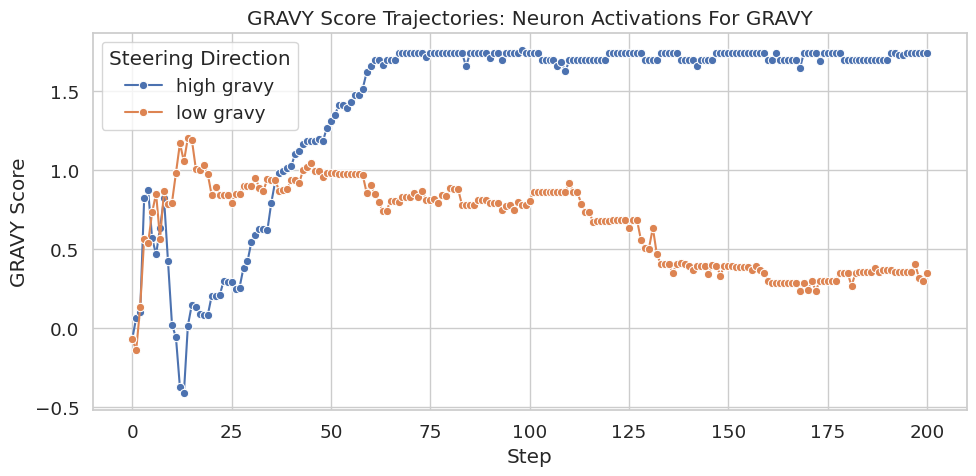

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForMaskedLM, AutoTokenizer
import random
import csv
import re
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Configuration
CSV_PATH = "esm3B_500k_neuron_explanations_redo.csv"
MODEL_NAME = "facebook/esm2_t36_3B_UR50D"
SEQ_LEN = 100
NUM_STEPS = 200
A = 2
B = 1

# Utilities
def find_matching_neurons(csv_path, keyword):
    matches = []
    with open(csv_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) < 2:
                continue
            neuron_id = row[0]
            if any(keyword in desc.lower() for desc in row[1:]):
                m = re.match(r"layer_(\d+)_neuron_(\d+)", neuron_id)
                if m:
                    matches.append((int(m.group(1)), int(m.group(2))))
    return matches

def make_multi_neuron_hook(neurons, a=10.0, b=3.0):
    def hook_fn(module, input, output):
        for neuron in neurons:
            output[:, :, neuron] = a * output[:, :, neuron] + b
        return output
    return hook_fn

def random_protein_sequence(length):
    return ''.join(random.choices("ACDEFGHIKLMNPQRSTVWY", k=length))

def sample_from_logits(logits):
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, num_samples=1).squeeze(-1)

def decode_tokens(tokenizer, token_ids):
    return tokenizer.decode(token_ids, skip_special_tokens=True).replace(" ", "")

def compute_gravy_ignore_x(seq):
    cleaned = seq.replace("X", "")
    if not cleaned:
        return None
    return ProteinAnalysis(cleaned).gravy()

# Main steering function
def steer(model, tokenizer, base_sequence, match_string, label):
    matched_neurons = find_matching_neurons(CSV_PATH, match_string)
    if not matched_neurons:
        print(f"No matching neurons found for: {match_string}")
        return []
    
    

    layer_to_neurons = defaultdict(list)
    for layer, neuron in matched_neurons:
        layer_to_neurons[layer].append(neuron)

    device = model.device
    history = []  # (step, sequence, activation, gravy)

    seq = base_sequence
    for step in tqdm(range(NUM_STEPS), desc=f"Steering for {label}"):
        inputs = tokenizer(seq, return_tensors="pt").to(device)

        handles = []
        for layer, neurons in layer_to_neurons.items():
            hook = model.base_model.encoder.layer[layer].intermediate.register_forward_hook(
                make_multi_neuron_hook(neurons, A, B)
            )
            handles.append(hook)

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits[0]
            hidden_states = outputs.hidden_states

        for h in handles:
            h.remove()

        # Score: average absolute activation across target neurons
        total, count = 0, 0
        for layer, neurons in layer_to_neurons.items():
            h = hidden_states[layer+1][0]
            for n in neurons:
                total += abs(h[:, n].mean().item())
                count += 1
        avg_act = total / count if count > 0 else 0

        sampled_ids = sample_from_logits(logits)
        seq = decode_tokens(tokenizer, sampled_ids)
        gravy = compute_gravy_ignore_x(seq)
        history.append((step + 1, seq, avg_act, gravy, label))

    return history

# Run both steering loops
if __name__ == "__main__":


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
    model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(device)
    model.eval()

    # Generate shared initial sequence
    base_sequence = random_protein_sequence(SEQ_LEN)
    print("Starting sequence:", base_sequence)

    # Run both steering directions
    history_pos = steer(model, tokenizer, base_sequence, "high gravy", label="high gravy")
    history_neg = steer(model, tokenizer, base_sequence, "low gravy", label="low gravy")
    # Add initial point (step 0) before steering
    initial_gravy = compute_gravy_ignore_x(base_sequence)
    init_row = (0, base_sequence, 0.0, initial_gravy, "high gravy")
    history_pos = [init_row] + history_pos
    init_row = (0, base_sequence, 0.0, initial_gravy, "low gravy")
    history_neg = [init_row] + history_neg

    # Save both to CSV
    with open("steered_sequences_dual.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["step", "sequence", "activation", "gravy", "label"])
        for row in history_pos + history_neg:
            writer.writerow(row)

    # Plot GRAVY score trajectories
    df = pd.DataFrame(history_pos + history_neg, columns=["step", "sequence", "activation", "gravy", "label"])
    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df, x="step", y="gravy", hue="label", marker="o")
    plt.xlabel("Step")
    plt.ylabel("GRAVY Score")
    plt.title("GRAVY Score Trajectories: Neuron Activations For GRAVY")
    plt.legend(title="Steering Direction")
    plt.tight_layout()
    plt.savefig("gravy_score_comparison.png")
    
    plt.show()


In [9]:
print(model.base_model.encoder.layer[layer])


NameError: name 'layer' is not defined

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForMaskedLM, AutoTokenizer
import random
import csv
import re
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Configuration
CSV_PATH = "esm3B_500k_neuron_explanations_redo.csv"
MODEL_NAME = "facebook/esm2_t36_3B_UR50D"
SEQ_LEN = 100
NUM_STEPS = 50
A = 2.0
B = 1.0

# --- Utilities ---

def find_matching_neurons(csv_path, keyword):
    matches = []
    with open(csv_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) < 2:
                continue
            neuron_id = row[0]
            if any(keyword in desc.lower() for desc in row[1:]):
                m = re.match(r"layer_(\d+)_neuron_(\d+)", neuron_id)
                if m:
                    matches.append((int(m.group(1)), int(m.group(2))))
    return matches

def make_multi_neuron_hook(neurons, a=10.0, b=3.0):
    def hook_fn(module, input, output):
        for neuron in neurons:
            output[:, :, neuron] = a * output[:, :, neuron] + b
        return output
    return hook_fn

def random_protein_sequence(length):
    return ''.join(random.choices("ACDEFGHIKLMNPQRSTVWY", k=length))

def compute_gravy_ignore_x(seq):
    cleaned = seq.replace("X", "")
    return ProteinAnalysis(cleaned).gravy() if cleaned else None

def mask_random_tokens(seq, tokenizer, fraction=0.1):
    tokens = list(seq)
    num_to_mask = max(1, int(fraction * len(tokens)))
    positions = random.sample(range(len(tokens)), k=num_to_mask)
    for idx in positions:
        tokens[idx] = tokenizer.mask_token
    return "".join(tokens), positions

# --- Main Loop ---

def steer_mlm(model, tokenizer, base_seq, match_string, label):
    matched_neurons = find_matching_neurons(CSV_PATH, match_string)
    if not matched_neurons:
        print(f"No matching neurons found for: {match_string}")
        return []

    layer_to_neurons = defaultdict(list)
    for layer, neuron in matched_neurons:
        layer_to_neurons[layer].append(neuron)

    device = model.device
    history = []

    seq = base_seq
    for step in tqdm(range(NUM_STEPS), desc=f"Steering: {label}"):
        masked_seq, mask_positions = mask_random_tokens(seq, tokenizer, fraction=0.1)
        inputs = tokenizer(masked_seq, return_tensors="pt").to(device)

        handles = []
        for layer, neurons in layer_to_neurons.items():
            hook = model.base_model.encoder.layer[layer].intermediate.register_forward_hook(
                make_multi_neuron_hook(neurons, A, B)
            )
            handles.append(hook)

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits[0]

        for h in handles:
            h.remove()

        input_ids = inputs["input_ids"][0]
        mask_token_id = tokenizer.mask_token_id
        mask_indices = (input_ids == mask_token_id).nonzero(as_tuple=True)[0]

        if len(mask_indices) == 0:
            print("Warning: No [MASK] tokens found.")
            continue

        seq_tokens = list(seq)
        for idx in mask_indices:
            probs = F.softmax(logits[idx], dim=-1)
            sampled_id = torch.multinomial(probs, num_samples=1).item()
            VALID_AAS = set("ACDEFGHIKLMNPQRSTVWY")
            predicted_token = tokenizer.convert_ids_to_tokens(sampled_id)

            if predicted_token in VALID_AAS:
                seq_tokens[seq_pos] = predicted_token
            else:
                # optional logging
                print(f"[Warning] Skipped invalid token: {predicted_token}") 

        seq = "".join(seq_tokens)
        gravy = compute_gravy_ignore_x(seq)

        # Score: avg absolute activation
        hidden_states = outputs.hidden_states
        total, count = 0, 0
        for layer, neurons in layer_to_neurons.items():
            h = hidden_states[layer + 1][0]  # +1 for embedding offset
            for n in neurons:
                total += abs(h[:, n].mean().item())
                count += 1
        avg_act = total / count if count > 0 else 0

        history.append((step + 1, seq, avg_act, gravy, label))

    return history

# --- Run both directions ---

if __name__ == "__main__":
    torch.manual_seed(42)
    random.seed(42)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(device)
    model.eval()

    base_seq = random_protein_sequence(SEQ_LEN)
    print("Initial sequence:", base_seq)

    history_hi = steer_mlm(model, tokenizer, base_seq, "high gravy", label="high gravy")
    history_lo = steer_mlm(model, tokenizer, base_seq, "low gravy", label="low gravy")

    # Add initial points
    init_gravy = compute_gravy_ignore_x(base_seq)
    init_row_hi = (0, base_seq, 0.0, init_gravy, "high gravy")
    init_row_lo = (0, base_seq, 0.0, init_gravy, "low gravy")
    history_hi = [init_row_hi] + history_hi
    history_lo = [init_row_lo] + history_lo

    # Save to CSV
    with open("steered_masked_sequences.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["step", "sequence", "activation", "gravy", "label"])
        for row in history_hi + history_lo:
            writer.writerow(row)

    # Plot
    df = pd.DataFrame(history_hi + history_lo, columns=["step", "sequence", "activation", "gravy", "label"])
    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df, x="step", y="gravy", hue="label", marker="o")
    plt.xlabel("Step")
    plt.ylabel("GRAVY Score")
    plt.title("Steering GRAVY via Multi-Mask Inpainting")
    plt.tight_layout()
    plt.savefig("gravy_masked_steering.png")
    plt.show()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at facebook/esm2_t36_3B_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial sequence: PAGFRQVCKAFMAEPMFNTATQHEYHCCTPTRMYINTPVNRAFGCFDGPIIFGWPPEREIYPNQTSFAHGFWVHQIWLGFNGNVIFYMCADPSKCIYMYV


Steering: high gravy:   0%|          | 0/50 [00:00<?, ?it/s]


NameError: name 'seq_pos' is not defined

Some weights of the model checkpoint at facebook/esm2_t12_35M_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial sequence: FGRWFDIAQFPQFEKDDAEDYGFAHATDFASREYAIGWLKFNTWNLAGAGPRSLAAAYGWFCSWLCRFFPMKLFFSAMGSCLATKVQVKWKVHLYRAHMSNLGDGIGIGSWNNRVNKPYSYQVHHCDWHQGGHWAQMDPRPGHCFLDVECRQFGVNAEFAYKSQMYQMSMIRYRYFWKSSPKNIVNTVWKPLGANDSCTQ
[(0, 15), (0, 0), (0, 18), (0, 19), (0, 31), (0, 1), (0, 14), (0, 4), (0, 23), (0, 30), (0, 42), (0, 36), (0, 52), (0, 60), (0, 48), (0, 43), (0, 56), (0, 41), (0, 61), (0, 46), (0, 50), (0, 53), (0, 63), (0, 62), (0, 40), (0, 66), (0, 64), (0, 77), (0, 74), (0, 86), (0, 88), (0, 68), (0, 71), (0, 80), (0, 87), (0, 84), (0, 92), (0, 96), (0, 90), (0, 99), (0, 85), (0, 95), (0, 97), (0, 107), (0, 102), (0, 117), (0, 113), (0, 110), (0, 114), (0, 100), (0, 103), (0, 122), (0, 108), (0, 129), (0, 133), (0, 131), (0, 135), (0, 143), (0, 138), (0, 141), (0, 132), (0, 155), (0, 166), (0, 163), (0, 140), (0, 167), (0, 168), (0, 165), (0, 174), (0, 169), (0, 170), (0, 161), (0, 181), (0, 184), (0, 185), (0, 176), (0, 187), (0, 188), (0, 180), (0, 178), (0, 186), (0, 193), (0, 19

Steering: high molecular:   9%|▉         | 9/100 [00:01<00:14,  6.07it/s]

[Warning] Skipped invalid token: X


Steering: high molecular:  20%|██        | 20/100 [00:03<00:15,  5.11it/s]

[Warning] Skipped invalid token: X


Steering: high molecular:  26%|██▌       | 26/100 [00:04<00:13,  5.69it/s]

[Warning] Skipped invalid token: X


Steering: high molecular:  50%|█████     | 50/100 [00:08<00:05,  8.72it/s]

[Warning] Skipped invalid token: X
[Warning] Skipped invalid token: X


Steering: high molecular:  57%|█████▋    | 57/100 [00:08<00:04,  8.88it/s]

[Warning] Skipped invalid token: X
[Warning] Skipped invalid token: X


Steering: high molecular:  71%|███████   | 71/100 [00:10<00:03,  8.87it/s]

[Warning] Skipped invalid token: X


Steering: high molecular:  75%|███████▌  | 75/100 [00:10<00:02,  8.81it/s]

[Warning] Skipped invalid token: X


Steering: high molecular:  95%|█████████▌| 95/100 [00:13<00:00,  8.92it/s]

[Warning] Skipped invalid token: X


Steering: high molecular: 100%|██████████| 100/100 [00:13<00:00,  7.28it/s]


[Warning] Skipped invalid token: X
[(0, 64), (0, 109), (0, 120), (0, 231), (0, 307), (0, 304), (0, 441), (0, 438), (1, 52), (1, 91), (1, 97), (1, 108), (1, 465), (2, 63), (2, 112), (2, 231), (2, 255), (2, 266), (2, 366), (2, 416), (2, 404), (3, 134), (3, 148), (3, 182), (3, 190), (3, 448), (3, 452), (4, 16), (4, 26), (4, 152), (4, 202), (4, 217), (4, 248), (4, 331), (4, 403), (5, 86), (5, 118), (5, 151), (5, 245), (5, 263), (5, 284), (5, 301), (5, 350), (5, 382), (5, 455), (6, 103), (6, 101), (6, 147), (6, 268), (6, 276), (7, 29), (7, 54), (7, 80), (7, 112), (7, 165), (7, 238), (7, 272), (7, 338), (7, 373), (8, 69), (8, 107), (8, 218), (8, 229), (8, 350), (8, 440), (9, 81), (9, 113), (9, 230), (9, 228), (9, 244), (9, 253), (9, 276), (10, 106), (10, 184), (10, 199), (10, 252), (10, 319), (10, 389), (10, 402), (10, 476), (11, 14), (11, 36), (11, 46), (11, 148), (11, 126), (11, 266), (11, 334), (11, 373)]


Steering: low molecular: 100%|██████████| 100/100 [00:01<00:00, 61.13it/s]


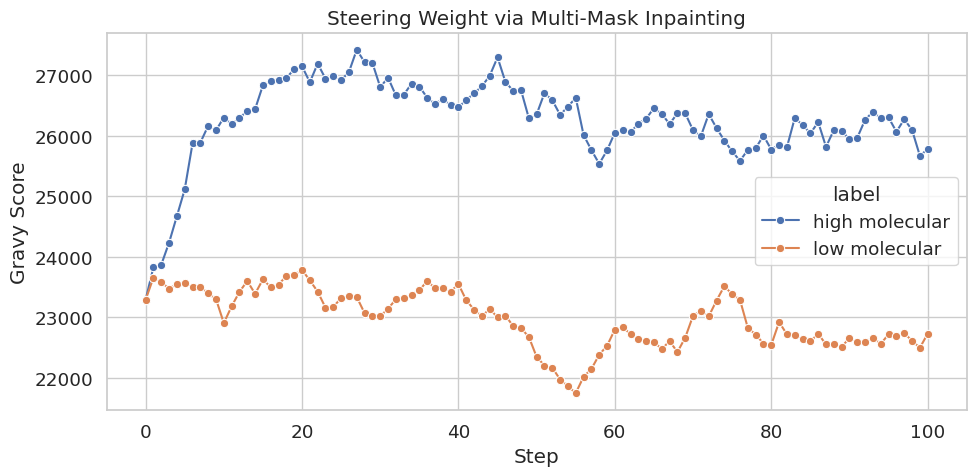

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForMaskedLM, AutoTokenizer
import random
import csv
import re
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Configuration
CSV_PATH = "esm35M_500k_neuron_explanations.csv"
MODEL_NAME = "facebook/esm2_t12_35M_UR50D"
SEQ_LEN = 200
NUM_STEPS = 100
A = 10
B = 3

# --- Utilities ---

def find_matching_neurons(csv_path, keyword):
    matches = []
    with open(csv_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) < 2:
                continue
            neuron_id = row[0]
            if any(keyword in desc.lower() for desc in row[1:]):
                m = re.match(r"layer_(\d+)_neuron_(\d+)", neuron_id)
                if m:
                    matches.append((int(m.group(1)), int(m.group(2))))
    return matches

def make_multi_neuron_hook(neurons, a=10.0, b=3.0):
    def hook_fn(module, input, output):
        for neuron in neurons:
            output[:, :, neuron] = a * output[:, :, neuron] + b
        return output
    return hook_fn

def random_protein_sequence(length):
    return ''.join(random.choices("ACDEFGHIKLMNPQRSTVWY", k=length))

def compute_gravy_ignore_x(seq):
    cleaned = seq.replace("X", "")
    return ProteinAnalysis(cleaned).gravy() if cleaned else None

def compute_weight_ignore_x(seq):
    cleaned = seq.replace("X", "")
    return ProteinAnalysis(cleaned).molecular_weight() if cleaned else None

def mask_random_tokens(seq, tokenizer, fraction=0.1):
    tokens = list(seq)
    num_to_mask = max(1, int(fraction * len(tokens)))
    positions = random.sample(range(len(tokens)), k=num_to_mask)
    for idx in positions:
        tokens[idx] = tokenizer.mask_token
    return "".join(tokens), positions

# --- Main Loop ---

def steer_mlm(model, tokenizer, base_seq, match_string, label):
    matched_neurons = find_matching_neurons(CSV_PATH, match_string)
    if not matched_neurons:
        print(f"No matching neurons found for: {match_string}")
        return []
    print(matched_neurons)

    layer_to_neurons = defaultdict(list)
    for layer, neuron in matched_neurons:
        layer_to_neurons[layer].append(neuron)
        

    device = model.device
    history = []

    seq = base_seq
    for step in tqdm(range(NUM_STEPS), desc=f"Steering: {label}"):
        masked_seq, mask_positions = mask_random_tokens(seq, tokenizer, fraction=0.1)
        inputs = tokenizer(masked_seq, return_tensors="pt").to(device)

        handles = []
        for layer, neurons in layer_to_neurons.items():
            hook = model.base_model.encoder.layer[layer].intermediate.register_forward_hook(
                make_multi_neuron_hook(neurons, A, B)
            )
            handles.append(hook)

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits[0]

        for h in handles:
            h.remove()

        input_ids = inputs["input_ids"][0]
        mask_token_id = tokenizer.mask_token_id
        mask_indices = (input_ids == mask_token_id).nonzero(as_tuple=True)[0]

        # Decode to get any special tokens added (e.g., BOS)
        token_ids = inputs["input_ids"][0].tolist()
        decoded_tokens = tokenizer.convert_ids_to_tokens(token_ids)
        offset = 1 if decoded_tokens[0] in tokenizer.all_special_tokens else 0

        token_ids = inputs["input_ids"][0].tolist()
        for idx in mask_indices:
            pos = idx.item()
            probs = F.softmax(logits[pos], dim=-1)
            sampled_id = torch.multinomial(probs, num_samples=1).item()
            predicted_token = tokenizer.convert_ids_to_tokens(sampled_id)

            if predicted_token in set("ACDEFGHIKLMNPQRSTVWY"):
                token_ids[pos] = sampled_id
            else:
                print(f"[Warning] Skipped invalid token: {predicted_token}")

        # Decode the full updated token sequence into a string
        seq = tokenizer.decode(token_ids, skip_special_tokens=True).replace(" ", "")
        weight = compute_weight_ignore_x(seq)

        # Score: avg absolute activation
        hidden_states = outputs.hidden_states
        total, count = 0, 0
        for layer, neurons in layer_to_neurons.items():
            h = hidden_states[layer + 1][0]  # +1 for embedding offset
            for n in neurons:
                total += abs(h[:, n].mean().item())
                count += 1
        avg_act = total / count if count > 0 else 0

        history.append((step + 1, seq, avg_act, weight, label))

    return history

# --- Run both directions ---

if __name__ == "__main__":


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(device)
    model.eval()

    base_seq = random_protein_sequence(SEQ_LEN)
    print("Initial sequence:", base_seq)

    history_hi = steer_mlm(model, tokenizer, base_seq, "high molecular", label="high molecular")
    history_lo = steer_mlm(model, tokenizer, base_seq, "low molecular", label="low molecular")

    # Add initial points
    init_weight = compute_weight_ignore_x(base_seq)
    init_row_hi = (0, base_seq, 0.0, init_weight, "high molecular")
    init_row_lo = (0, base_seq, 0.0, init_weight, "low molecular")
    history_hi = [init_row_hi] + history_hi
    history_lo = [init_row_lo] + history_lo



    # Plot
    df = pd.DataFrame(history_hi + history_lo, columns=["step", "sequence", "activation", "gravy", "label"])
    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df, x="step", y="gravy", hue="label", marker="o")
    plt.xlabel("Step")
    plt.ylabel("Gravy Score")
    plt.title("Steering Weight via Multi-Mask Inpainting")
    plt.tight_layout()
    plt.savefig("gravy_masked_steering.png")
    plt.show()


Some weights of the model checkpoint at facebook/esm2_t12_35M_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial sequence: EVPSCAWKTKGPCNSEGLFYSTCGISIQEYVSDYKAKYKLQKFPAIGDNNDRLGGAYPYSISIFRLFKQNLDADYVSAAHKGWDKICKKSLFACICKTCTHRMMQECYQWAVALNWQTITHCWKERSDVSEQMNPLGWGFGGAVGTCGLFSHNNFFIMNELQEERGCKEAMLWFKHHRGFQQKYMNNWGYRMYENYDNVL
[(0, 15), (0, 0), (0, 18), (0, 19), (0, 31), (0, 1), (0, 14), (0, 4), (0, 23), (0, 30), (0, 42), (0, 36), (0, 52), (0, 60), (0, 48), (0, 43), (0, 56), (0, 41), (0, 61), (0, 46), (0, 50), (0, 53), (0, 63), (0, 62), (0, 40), (0, 66), (0, 64), (0, 77), (0, 74), (0, 86), (0, 88), (0, 68), (0, 71), (0, 80), (0, 87), (0, 84), (0, 92), (0, 96), (0, 90), (0, 99), (0, 85), (0, 95), (0, 97), (0, 107), (0, 102), (0, 117), (0, 113), (0, 110), (0, 114), (0, 100), (0, 103), (0, 122), (0, 108), (0, 129), (0, 133), (0, 131), (0, 135), (0, 143), (0, 138), (0, 141), (0, 132), (0, 155), (0, 166), (0, 163), (0, 140), (0, 167), (0, 168), (0, 165), (0, 174), (0, 169), (0, 170), (0, 161), (0, 181), (0, 184), (0, 185), (0, 176), (0, 187), (0, 188), (0, 180), (0, 178), (0, 186), (0, 193), (0, 19

Steering: high molecular: 100%|██████████| 100/100 [00:13<00:00,  7.61it/s]


[(0, 64), (0, 109), (0, 120), (0, 231), (0, 307), (0, 304), (0, 441), (0, 438), (1, 52), (1, 91), (1, 97), (1, 108), (1, 465), (2, 63), (2, 112), (2, 231), (2, 255), (2, 266), (2, 366), (2, 416), (2, 404), (3, 134), (3, 148), (3, 182), (3, 190), (3, 448), (3, 452), (4, 16), (4, 26), (4, 152), (4, 202), (4, 217), (4, 248), (4, 331), (4, 403), (5, 86), (5, 118), (5, 151), (5, 245), (5, 263), (5, 284), (5, 301), (5, 350), (5, 382), (5, 455), (6, 103), (6, 101), (6, 147), (6, 268), (6, 276), (7, 29), (7, 54), (7, 80), (7, 112), (7, 165), (7, 238), (7, 272), (7, 338), (7, 373), (8, 69), (8, 107), (8, 218), (8, 229), (8, 350), (8, 440), (9, 81), (9, 113), (9, 230), (9, 228), (9, 244), (9, 253), (9, 276), (10, 106), (10, 184), (10, 199), (10, 252), (10, 319), (10, 389), (10, 402), (10, 476), (11, 14), (11, 36), (11, 46), (11, 148), (11, 126), (11, 266), (11, 334), (11, 373)]


Steering: low molecular:  42%|████▏     | 42/100 [00:00<00:00, 60.93it/s]

[Warning] Skipped invalid token: X


Steering: low molecular:  63%|██████▎   | 63/100 [00:01<00:00, 61.01it/s]

[Warning] Skipped invalid token: X


Steering: low molecular: 100%|██████████| 100/100 [00:01<00:00, 60.92it/s]


[(0, 10), (0, 38), (0, 98), (0, 163), (0, 285), (0, 336), (0, 367), (0, 453), (1, 4), (1, 21), (1, 31), (1, 106), (1, 163), (1, 273), (1, 300), (1, 378), (1, 470), (2, 12), (2, 31), (2, 25), (2, 38), (2, 125), (2, 141), (2, 176), (2, 247), (2, 257), (2, 338), (3, 18), (3, 132), (3, 247), (3, 262), (5, 421), (6, 76), (6, 107), (6, 170), (6, 237), (7, 212), (7, 342), (7, 449), (8, 162), (8, 187), (8, 292), (9, 33), (9, 338), (9, 457), (10, 69), (10, 155), (10, 314), (10, 412), (11, 131), (11, 193), (11, 283), (11, 457)]


Steering: high gravy: 100%|██████████| 100/100 [00:01<00:00, 68.47it/s]


[(0, 13), (0, 4), (0, 8), (0, 9), (0, 32), (0, 42), (0, 60), (0, 51), (0, 49), (0, 89), (0, 82), (0, 111), (0, 105), (0, 108), (0, 130), (0, 115), (0, 142), (0, 152), (0, 146), (0, 151), (0, 150), (0, 158), (0, 148), (0, 144), (0, 179), (0, 180), (0, 178), (0, 194), (0, 204), (0, 209), (0, 198), (0, 223), (0, 227), (0, 235), (0, 243), (0, 247), (0, 248), (0, 258), (0, 241), (0, 272), (0, 261), (0, 284), (0, 278), (0, 296), (0, 294), (0, 295), (0, 299), (0, 327), (0, 323), (0, 345), (0, 348), (0, 356), (0, 362), (0, 368), (0, 383), (0, 388), (0, 395), (0, 401), (0, 409), (0, 396), (0, 412), (0, 421), (0, 416), (0, 429), (0, 435), (0, 432), (0, 436), (0, 449), (0, 455), (0, 469), (0, 465), (0, 476), (0, 472), (1, 11), (1, 9), (1, 2), (1, 27), (1, 29), (1, 51), (1, 55), (1, 52), (1, 48), (1, 67), (1, 73), (1, 83), (1, 105), (1, 97), (1, 101), (1, 116), (1, 131), (1, 150), (1, 144), (1, 155), (1, 174), (1, 177), (1, 179), (1, 197), (1, 202), (1, 198), (1, 209), (1, 224), (1, 228), (1, 226)

Steering: low gravy:   3%|▎         | 3/100 [00:00<00:03, 26.56it/s]

[Warning] Skipped invalid token: X
[Warning] Skipped invalid token: X
[Warning] Skipped invalid token: X


Steering: low gravy:   6%|▌         | 6/100 [00:00<00:03, 25.58it/s]

[Warning] Skipped invalid token: X
[Warning] Skipped invalid token: <eos>


Steering: low gravy:  15%|█▌        | 15/100 [00:00<00:03, 25.74it/s]

[Warning] Skipped invalid token: X
[Warning] Skipped invalid token: X
[Warning] Skipped invalid token: X


Steering: low gravy:  30%|███       | 30/100 [00:01<00:02, 25.66it/s]

[Warning] Skipped invalid token: X
[Warning] Skipped invalid token: X
[Warning] Skipped invalid token: X


Steering: low gravy:  42%|████▏     | 42/100 [00:01<00:02, 25.72it/s]

[Warning] Skipped invalid token: X
[Warning] Skipped invalid token: X
[Warning] Skipped invalid token: X


Steering: low gravy:  48%|████▊     | 48/100 [00:01<00:02, 25.83it/s]

[Warning] Skipped invalid token: X


Steering: low gravy:  54%|█████▍    | 54/100 [00:02<00:01, 25.87it/s]

[Warning] Skipped invalid token: X
[Warning] Skipped invalid token: X
[Warning] Skipped invalid token: X
[Warning] Skipped invalid token: X


Steering: low gravy:  63%|██████▎   | 63/100 [00:02<00:01, 25.86it/s]

[Warning] Skipped invalid token: X
[Warning] Skipped invalid token: X


Steering: low gravy:  72%|███████▏  | 72/100 [00:02<00:01, 25.88it/s]

[Warning] Skipped invalid token: X
[Warning] Skipped invalid token: <eos>


Steering: low gravy:  78%|███████▊  | 78/100 [00:03<00:00, 26.04it/s]

[Warning] Skipped invalid token: X


Steering: low gravy:  87%|████████▋ | 87/100 [00:03<00:00, 25.94it/s]

[Warning] Skipped invalid token: X
[Warning] Skipped invalid token: X


Steering: low gravy: 100%|██████████| 100/100 [00:03<00:00, 25.87it/s]


[Warning] Skipped invalid token: X
[(0, 21), (0, 15), (0, 24), (0, 27), (0, 61), (0, 53), (0, 59), (0, 47), (0, 75), (0, 92), (0, 85), (0, 119), (0, 105), (0, 124), (0, 118), (0, 127), (0, 129), (0, 116), (0, 143), (0, 152), (0, 153), (0, 150), (0, 158), (0, 156), (0, 173), (0, 172), (0, 179), (0, 200), (0, 201), (0, 202), (0, 238), (0, 231), (0, 237), (0, 253), (0, 257), (0, 262), (0, 259), (0, 267), (0, 271), (0, 287), (0, 295), (0, 300), (0, 334), (0, 329), (0, 340), (0, 344), (0, 356), (0, 364), (0, 366), (0, 380), (0, 370), (0, 378), (0, 382), (0, 379), (0, 388), (0, 395), (0, 398), (0, 402), (0, 421), (0, 431), (0, 442), (0, 438), (0, 443), (0, 449), (1, 2), (1, 6), (0, 467), (1, 28), (1, 34), (1, 44), (1, 42), (1, 57), (1, 64), (1, 88), (1, 105), (1, 100), (1, 107), (1, 127), (1, 133), (1, 138), (1, 155), (1, 186), (1, 197), (1, 184), (1, 201), (1, 199), (1, 259), (1, 277), (1, 271), (1, 278), (1, 287), (1, 290), (1, 291), (1, 307), (1, 302), (1, 342), (1, 346), (1, 359), (1, 36

Steering: high instability:  12%|█▏        | 12/100 [00:00<00:02, 31.13it/s]

[Warning] Skipped invalid token: <pad>


Steering: high instability:  44%|████▍     | 44/100 [00:01<00:01, 30.87it/s]

[Warning] Skipped invalid token: X


Steering: high instability:  64%|██████▍   | 64/100 [00:02<00:01, 31.15it/s]

[Warning] Skipped invalid token: X


Steering: high instability:  76%|███████▌  | 76/100 [00:02<00:00, 30.96it/s]

[Warning] Skipped invalid token: X


Steering: high instability:  84%|████████▍ | 84/100 [00:02<00:00, 31.00it/s]

[Warning] Skipped invalid token: <mask>
[Warning] Skipped invalid token: <cls>


Steering: high instability: 100%|██████████| 100/100 [00:03<00:00, 31.00it/s]


[Warning] Skipped invalid token: <unk>
[(0, 439), (0, 437), (3, 178), (3, 208), (5, 3), (5, 479), (6, 47), (8, 220)]


Steering: low instability: 100%|██████████| 100/100 [00:01<00:00, 83.56it/s]


Using 50 random neurons as control
[(2, 217), (4, 396), (10, 310), (11, 346), (1, 280), (8, 54), (1, 3), (5, 127), (7, 399), (1, 229), (10, 298), (8, 203), (4, 46), (9, 323), (4, 215), (10, 73), (10, 391), (1, 326), (3, 467), (9, 438), (0, 334), (9, 88), (7, 404), (1, 39), (9, 146), (11, 227), (0, 430), (6, 170), (0, 216), (3, 447), (4, 270), (0, 156), (2, 66), (1, 428), (2, 337), (6, 152), (3, 145), (7, 425), (3, 356), (9, 107), (1, 254), (9, 413), (0, 0), (6, 98), (9, 263), (8, 116), (10, 437), (1, 78), (5, 40), (11, 92)]


Steering: high control: 100%|██████████| 100/100 [00:01<00:00, 69.04it/s]


Using 50 random neurons as control
[(11, 14), (7, 153), (11, 81), (11, 61), (4, 118), (8, 143), (1, 171), (7, 464), (4, 103), (4, 97), (3, 175), (3, 445), (8, 95), (0, 454), (9, 364), (3, 203), (5, 6), (11, 192), (11, 448), (6, 131), (4, 452), (5, 152), (4, 141), (6, 283), (8, 323), (7, 266), (10, 235), (3, 391), (9, 176), (0, 31), (7, 254), (0, 389), (9, 273), (5, 355), (11, 344), (11, 36), (2, 8), (3, 36), (5, 317), (8, 152), (1, 310), (9, 118), (1, 437), (2, 453), (8, 264), (11, 353), (10, 52), (0, 221), (11, 327), (2, 73)]


Steering: low control: 100%|██████████| 100/100 [00:01<00:00, 69.49it/s]


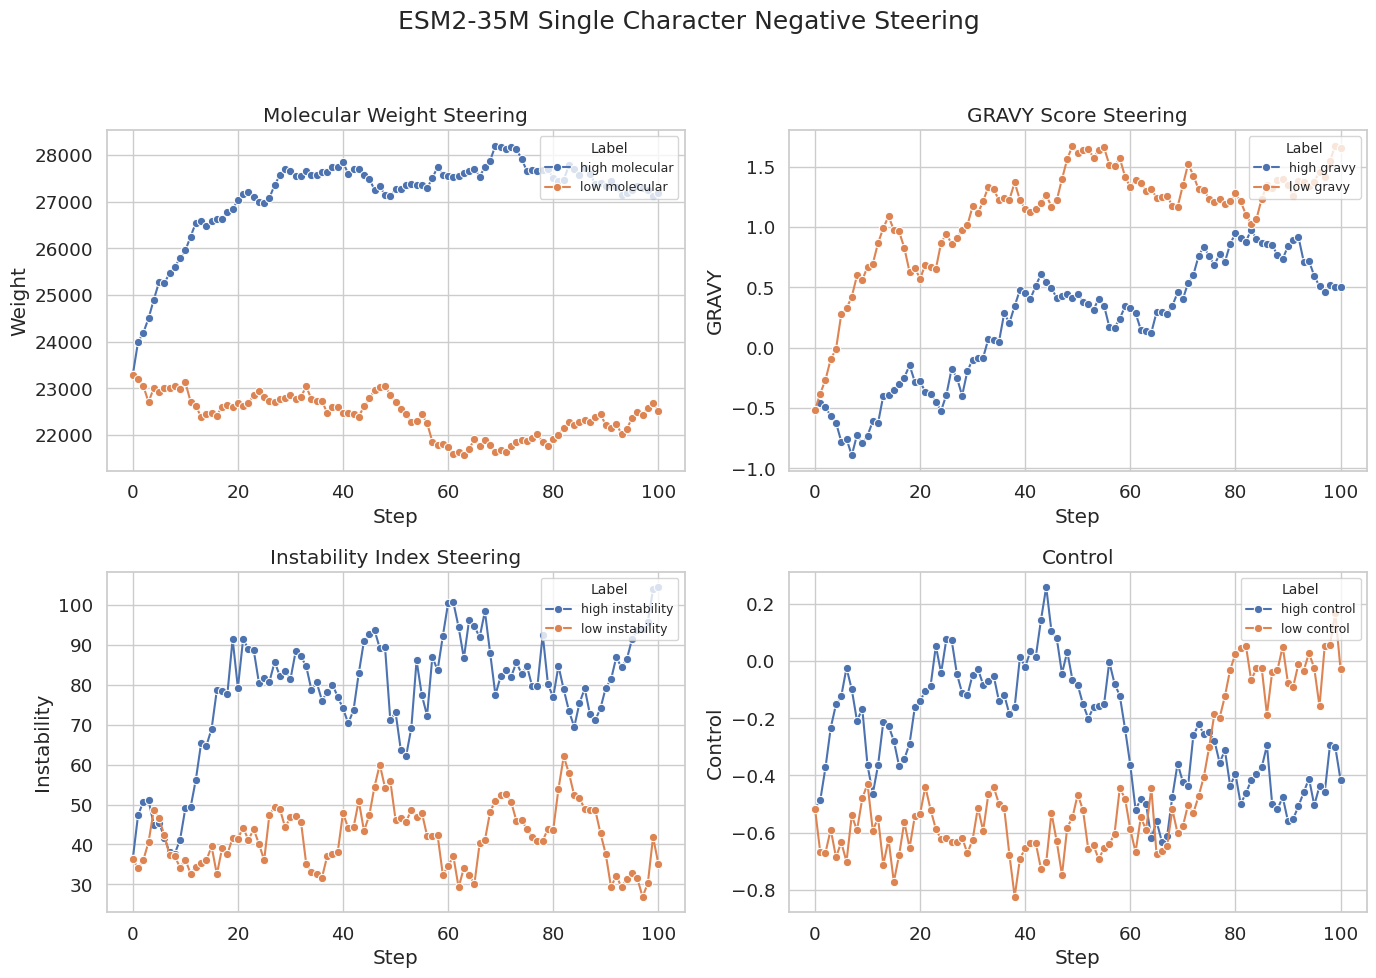

Saved combined CSV to: 35M_not_original_steering_metrics_all.csv


In [82]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForMaskedLM, AutoTokenizer
import random
import csv
import re
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from Bio.SeqUtils.ProtParam import ProteinAnalysis


# Configuration
CSV_PATH = "esm35M_500k_neuron_explanations.csv"
MODEL_NAME = "facebook/esm2_t12_35M_UR50D"
SEQ_LEN = 200
NUM_STEPS = 100
A = 10
B = 3

# --- Utilities ---

def find_matching_neurons(csv_path, keyword):
    matches = []
    with open(csv_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) < 2:
                continue
            neuron_id = row[0]
            if any(keyword in desc.lower() for desc in row[1:]):
                m = re.match(r"layer_(\d+)_neuron_(\d+)", neuron_id)
                if m:
                    matches.append((int(m.group(1)), int(m.group(2))))
    return matches

def make_multi_neuron_hook(neurons, a=10.0, b=3.0):
    def hook_fn(module, input, output):
        for neuron in neurons:
            output[:, :, neuron] = a * output[:, :, neuron] + b
        return output
    return hook_fn

def random_protein_sequence(length):
    return ''.join(random.choices("ACDEFGHIKLMNPQRSTVWY", k=length))

def compute_gravy_ignore_x(seq):
    cleaned = seq.replace("X", "")
    return ProteinAnalysis(cleaned).gravy() if cleaned else None

def compute_weight_ignore_x(seq):
    cleaned = seq.replace("X", "")
    return ProteinAnalysis(cleaned).molecular_weight() if cleaned else None

def compute_instability_index_ignore_x(seq):
    cleaned = seq.replace("X", "")
    return ProteinAnalysis(cleaned).instability_index() if cleaned else None

def mask_random_tokens(seq, tokenizer, fraction=0.1):
    tokens = list(seq)
    num_to_mask = max(1, int(fraction * len(tokens)))
    positions = random.sample(range(len(tokens)), k=num_to_mask)
    for idx in positions:
        tokens[idx] = tokenizer.mask_token
    return "".join(tokens), positions


def random_neurons(num_random_neurons):
    matched_neurons = []
    # Get total number of layers and neurons from the model
    num_layers = len(model.base_model.encoder.layer)
    #num_neurons = model.base_model.encoder.layer[0].intermediate.dense.out_features
    hidden_size = model.config.hidden_size
    
    # Select num_random_neurons random neurons from random layers
    for _ in range(num_random_neurons):
        layer = random.randint(0, num_layers - 1)
        #neuron = random.randint(0, num_neurons - 1)
        neuron = random.randint(0, hidden_size - 1)
        matched_neurons.append((layer, neuron))
    
    print(f"Using {len(matched_neurons)} random neurons as control")
    return matched_neurons



def steer_mlm(model, tokenizer, base_seq, match_string, metric, label, a, b, use_random_neurons=False, num_random_neurons=50):
    if use_random_neurons:
        matched_neurons = random_neurons(num_random_neurons)
    else:
        matched_neurons = find_matching_neurons(CSV_PATH, match_string)
    if not matched_neurons:
        print(f"No matching neurons found for: {match_string}")
        return []
    print(matched_neurons)

    layer_to_neurons = defaultdict(list)
    for layer, neuron in matched_neurons:
        layer_to_neurons[layer].append(neuron)
        

    device = model.device
    history = []

    seq = base_seq
    for step in tqdm(range(NUM_STEPS), desc=f"Steering: {label}"):
        masked_seq, mask_positions = mask_random_tokens(seq, tokenizer, fraction=0.1)
        inputs = tokenizer(masked_seq, return_tensors="pt").to(device)

        handles = []
        for layer, neurons in layer_to_neurons.items():
            hook = model.base_model.encoder.layer[layer].intermediate.register_forward_hook(
                make_multi_neuron_hook(neurons, a, b)
            )
            handles.append(hook)

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits[0]

        for h in handles:
            h.remove()

        input_ids = inputs["input_ids"][0]
        mask_token_id = tokenizer.mask_token_id
        mask_indices = (input_ids == mask_token_id).nonzero(as_tuple=True)[0]

        # Decode to get any special tokens added (e.g., BOS)
        token_ids = inputs["input_ids"][0].tolist()
        decoded_tokens = tokenizer.convert_ids_to_tokens(token_ids)
        offset = 1 if decoded_tokens[0] in tokenizer.all_special_tokens else 0

        token_ids = inputs["input_ids"][0].tolist()
        for idx in mask_indices:
            pos = idx.item()
            probs = F.softmax(logits[pos], dim=-1)
            sampled_id = torch.multinomial(probs, num_samples=1).item()
            predicted_token = tokenizer.convert_ids_to_tokens(sampled_id)

            if predicted_token in set("ACDEFGHIKLMNPQRSTVWY"):
                token_ids[pos] = sampled_id
            else:
                print(f"[Warning] Skipped invalid token: {predicted_token}")

        # Decode the full updated token sequence into a string
        seq = tokenizer.decode(token_ids, skip_special_tokens=True).replace(" ", "")
        log_metric = metric(seq)

        # Score: avg absolute activation
        hidden_states = outputs.hidden_states
        total, count = 0, 0
        for layer, neurons in layer_to_neurons.items():
            h = hidden_states[layer + 1][0]  # +1 for embedding offset
            for n in neurons:
                total += abs(h[:, n].mean().item())
                count += 1
        avg_act = total / count if count > 0 else 0

        history.append((step + 1, seq, avg_act, log_metric, label))

    return history

def plot_activation_2x2_grid(paired_histories, y_labels, title="Neuron Steering Metrics (2×2)", filename="metric_2x2.png"):
    """
    Plot metric trajectories for 4 steering histories in a 2x2 grid.

    Args:
        paired_histories: List of 4 tuples:
            (subplot_title: str, df_combined: pd.DataFrame),
            where each df has ['step', 'metric_value', 'label']
        y_labels: List of 4 strings — y-axis labels for each subplot
        title: Global plot title
        filename: Output file path
    """
    assert len(paired_histories) == 4, "Expected exactly 4 history pairs for 2x2 grid."
    assert len(y_labels) == 4, "Expected 4 y-axis labels."

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    sns.set(style="whitegrid", font_scale=1.2)

    for ax, (subplot_title, df), y_label in zip(axes.flat, paired_histories, y_labels):
        sns.lineplot(data=df, x="step", y="metric_value", hue="label", marker="o", ax=ax)
        ax.set_title(subplot_title)
        ax.set_xlabel("Step")
        ax.set_ylabel(y_label)
        ax.legend(title="Label", loc="upper right", fontsize=9, title_fontsize=10)


    plt.suptitle(title, fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(filename)
    plt.show()


def save_all_metrics_to_csv(metric_dfs, metric_names, output_path="all_steering_metrics.csv"):
    """
    Save all metric DataFrames into one combined CSV with a 'metric_name' column.

    Args:
        metric_dfs: List of 4 pd.DataFrame objects (must have ['step', 'metric_value', 'label'])
        metric_names: List of 4 strings corresponding to metric names
        output_path: Filename for the combined CSV
    """
    assert len(metric_dfs) == len(metric_names), "Mismatch between DataFrames and metric names."

    combined_rows = []
    for df, name in zip(metric_dfs, metric_names):
        temp = df.copy()
        temp["metric_name"] = name
        combined_rows.append(temp)

    df_all = pd.concat(combined_rows, ignore_index=True)
    df_all.to_csv(output_path, index=False)
    print(f"Saved combined CSV to: {output_path}")






if __name__ == "__main__":


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(device)
    model.eval()

    base_seq = random_protein_sequence(SEQ_LEN)
    print("Initial sequence:", base_seq)

    #weight
    history_hi_weight = steer_mlm(model, tokenizer, base_seq, "high molecular", compute_weight_ignore_x, label="high molecular", a=-10, b=-8)
    history_lo_weight = steer_mlm(model, tokenizer, base_seq, "low molecular", compute_weight_ignore_x, label="low molecular", a=-10, b=-8)

    #gravy
    history_hi_gravy = steer_mlm(model, tokenizer, base_seq, "high gravy", compute_gravy_ignore_x, label="high gravy", a=-10, b=-8)
    history_lo_gravy = steer_mlm(model, tokenizer, base_seq, "low gravy", compute_gravy_ignore_x, label="low gravy", a=-10, b=-8)

    #instability index
    history_hi_instability = steer_mlm(model, tokenizer, base_seq, "high instability", compute_instability_index_ignore_x, label="high instability", a=-10 , b=-8)
    history_lo_instability = steer_mlm(model, tokenizer, base_seq, "low instability", compute_instability_index_ignore_x, label="low instability", a=-10, b=-8)

    #control    
    history_hi_control = steer_mlm(model, tokenizer, base_seq, "high gravy", compute_gravy_ignore_x, label="high control", a=-10, b=-3, use_random_neurons=True, num_random_neurons=50)
    history_lo_control = steer_mlm(model, tokenizer, base_seq, "low gravy", compute_gravy_ignore_x, label="low control", a=-10, b=-3, use_random_neurons=True, num_random_neurons=50)

    # Add initial points
    init_weight = compute_weight_ignore_x(base_seq)
    history_hi_weight = [(0, base_seq, 0.0, init_weight, "high molecular")] + history_hi_weight
    history_lo_weight = [(0, base_seq, 0.0, init_weight, "low molecular")] + history_lo_weight

    init_gravy = compute_gravy_ignore_x(base_seq)
    history_hi_gravy = [(0, base_seq, 0.0, init_gravy, "high gravy")] + history_hi_gravy
    history_lo_gravy = [(0, base_seq, 0.0, init_gravy, "low gravy")] + history_lo_gravy

    init_instability = compute_instability_index_ignore_x(base_seq)
    history_hi_instability = [(0, base_seq, 0.0, init_instability, "high instability")] + history_hi_instability
    history_lo_instability = [(0, base_seq, 0.0, init_instability, "low instability")] + history_lo_instability

    init_control = compute_gravy_ignore_x(base_seq)
    history_hi_control = [(0, base_seq, 0.0, init_control, "high control")] + history_hi_control
    history_lo_control = [(0, base_seq, 0.0, init_control, "low control")] + history_lo_control




    # Plot 4 plots in 1 grid
    df_weight = pd.concat([
        pd.DataFrame(history_hi_weight, columns=["step", "sequence", "activation", "metric_value", "label"])[["step", "metric_value", "label"]],
        pd.DataFrame(history_lo_weight, columns=["step", "sequence", "activation", "metric_value", "label"])[["step", "metric_value", "label"]]
    ], ignore_index=True)

    df_gravy = pd.concat([
        pd.DataFrame(history_hi_gravy, columns=["step", "sequence", "activation", "metric_value", "label"])[["step", "metric_value", "label"]],
        pd.DataFrame(history_lo_gravy, columns=["step", "sequence", "activation", "metric_value", "label"])[["step", "metric_value", "label"]]
    ], ignore_index=True)

    df_instab = pd.concat([
        pd.DataFrame(history_hi_instability, columns=["step", "sequence", "activation", "metric_value", "label"])[["step", "metric_value", "label"]],
        pd.DataFrame(history_lo_instability, columns=["step", "sequence", "activation", "metric_value", "label"])[["step", "metric_value", "label"]]
    ], ignore_index=True)

    df_control = pd.concat([
        pd.DataFrame(history_hi_control, columns=["step", "sequence", "activation", "metric_value", "label"])[["step", "metric_value", "label"]],
        pd.DataFrame(history_lo_control, columns=["step", "sequence", "activation", "metric_value", "label"])[["step", "metric_value", "label"]]
    ], ignore_index=True)

    # Plot all 4
    plot_activation_2x2_grid(
        paired_histories=[
            ("Molecular Weight Steering", df_weight),
            ("GRAVY Score Steering", df_gravy),
            ("Instability Index Steering", df_instab),
            ("Control", df_control)
        ],
        y_labels=["Weight", "GRAVY", "Instability", "Control"],
        title="ESM2-35M Single Character Negative Steering",
        filename="activation_grid_2x2.png"
    )

    save_all_metrics_to_csv(
    metric_dfs=[df_weight, df_gravy, df_instab, df_control],
    metric_names=["Molecular Weight", "GRAVY Score", "Instability Index", "Control"],
    output_path="35M_not_original_steering_metrics_all.csv"
)